In [1]:
import zhusuan as zs
import tensorflow as tf
import numpy as np
import sys
from matplotlib import pyplot as plt
from zhusuan.variational import svgd
import seaborn as sns
%matplotlib inline

In [2]:
sess = tf.InteractiveSession()

In [3]:
@zs.reuse('model')
def build_model(observed):
    with zs.BayesianNet(observed) as model:
        dist = zs.MultivariateNormalCholesky(
            name='dist',
            mean=np.array([-1, 0.5],dtype='f'), 
            cov_tril=np.linalg.cholesky([[4, 0.5], [0.5, 2]]).astype('f'))
    return model, dist

_, dist = build_model(None)

dist_vals = tf.get_variable(
    'dist_v',
    [200, 2],
    tf.float32,
    tf.random_uniform_initializer(-1, 1)
)

def log_joint(observed):
    m, d = build_model(observed)
    return m.local_log_prob('dist')

grad_and_vars = svgd.stein_variational_gradient(
    log_joint, {'dist': dist_vals})
optimizer = tf.train.AdamOptimizer(0.01)
opt_op = optimizer.apply_gradients([(-g, v) for g, v in grad_and_vars])

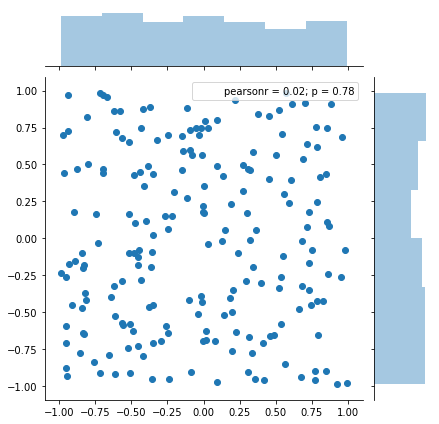

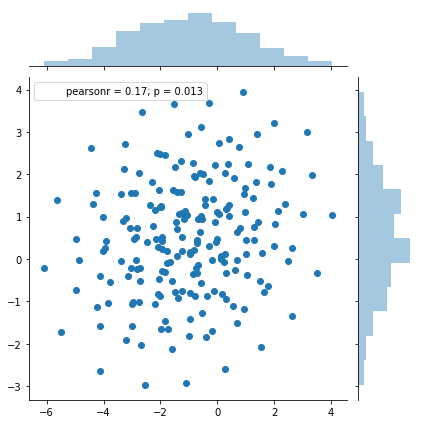

In [5]:
sess.run(tf.global_variables_initializer())

particles = sess.run(grad_and_vars[0][1])
sns.jointplot(particles[:, 0], particles[:, 1])
for i in range(2000):
    _, g, v = sess.run([opt_op, grad_and_vars[0][0], grad_and_vars[0][1]])
    # print(np.mean(g), np.mean(v))

particles = sess.run(grad_and_vars[0][1])
sns.jointplot(particles[:, 0], particles[:, 1])

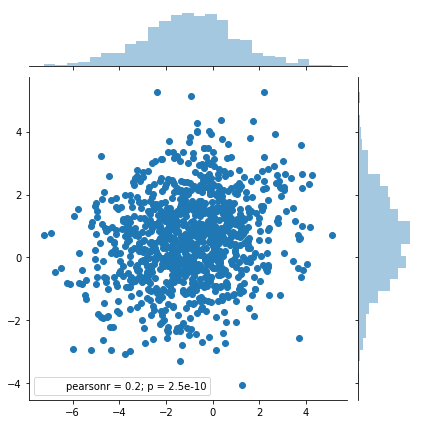

In [8]:
particles1 = (sess.run(dist.sample(1000)))
sns.jointplot(particles1[:, 0], particles1[:, 1])


In [10]:
np.mean(particles,axis=0)

array([-1.00425 ,  0.495824], dtype=float32)

In [12]:
np.cov(particles.T)

array([[3.79573178, 0.46948284],
       [0.46948284, 1.89859602]])